In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Concatenate,Dense, Activation, Dropout, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform,HeUniform
import imgaug.augmenters as iaa
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
import numpy as np
from segmentation_models.metrics import iou_score
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
import albumentations as A
import segmentation_models as sm
import os
from pycocotools.coco import COCO
from typing import Any, Callable, List, Optional, Tuple
from pathlib import Path
import skimage.io as io
K.set_image_data_format('channels_last')
from canet_model import convolutional_block,identity_block,global_flow,context_flow,agcn,fsm
sm.set_framework('tf.keras')

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(sm.__version__)

Segmentation Models: using `keras` framework.
2.8.0
1.22.2
4.5.5
1.0.1


In [3]:
def get_vgg_16_backbone():
    tf.keras.backend.clear_session()
    vgg_16 = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None,
                                               input_shape=(512,512,3))
    block3_c1 = vgg_16.get_layer('block3_conv1').output
    backbone = Model(vgg_16.layers[0].input, block3_c1)
    return backbone

In [4]:
class vgg_backbone(tf.keras.layers.Layer):
    
    def __init__(self,name="backbone_block"):
        super().__init__()
        self.backbone = get_vgg_16_backbone()
    def call(self, X):
        X = self.backbone(X)
        return X
    
def create_cmodel():
    
    tf.keras.backend.clear_session()
    start_filters = np.array([4,4,8])
    n_classes = 1
    
    input = Input((512,512,3))
    m = vgg_backbone()(input)
    print(f'Backbone output shape : {m.shape}')
    m = tf.keras.layers.Conv2D(8, 1, 1, "same")(m)

    c1 = m
    c =  convolutional_block(kernel=3,  filters=list(2*start_filters), stride=2,name='conv_block_c2')(m)
    c =  identity_block(kernel=3,  filters=list(2*start_filters),name='indentity_block_c2')(c)

    c =  convolutional_block(kernel=3,  filters=list(4*start_filters), stride=1,name='conv_block_c3')(c)
    c =  identity_block(kernel=3,  filters=list(4*start_filters),name='indentity_block_c3')(c)

    c =  convolutional_block(kernel=3,  filters=list(8*start_filters), stride=1,name='conv_block_c4')(c)
    c =  identity_block(kernel=3,  filters=list(8*start_filters),name='indentity_block_c4')(c)
    c4 = c #c4

    # Global Flow
    w,h,c = c4.shape[1:]
    gf = global_flow(w,h,do_upsample=True,channels=c)(c4)

    #Context flow 1
    channels = gf.shape[-1]

    cf1_in = [c4,gf]
    cf1 = context_flow(channels=channels,name='context_flow1')(cf1_in)

    #Context flow 2
    cf2_in = [c4,cf1]
    cf2 = context_flow(channels=channels,name='context_flow2')(cf2_in)

    #Context flow 3
    cf3_in = [c4,cf2]
    cf3 = context_flow(channels=channels,name='context_flow3')(cf3_in)

    # Add outputs of context flows & global_flow
    cf_add = Add()([gf,cf1,cf2,cf3])

    # Feature selection module
    fsm_out = fsm(channels=cf_add.shape[-1])(cf_add)
    agcn_out = agcn(channels=m.shape[-1])(c1)

    agcn_fsm_concat = Concatenate()([fsm_out, agcn_out])

    conv3x3_out = Conv2D(n_classes,
                    kernel_size=(3,3),
                    strides=(1,1),activation="relu",
                    padding="same",name='conv_out',
                    kernel_initializer=HeUniform)(agcn_fsm_concat)

    upsample = UpSampling2D(size=(4,4),interpolation='bilinear',name='upsampled_out')(conv3x3_out)

    upsample = BatchNormalization(axis=-1,name='BN_out')(upsample)
    conv3x3_output = Conv2D(n_classes,kernel_size=(3,3),strides=(1,1),padding='same', kernel_initializer=HeUniform,
                            name='conv3x3_output')(upsample)

    output = Activation("sigmoid",name='SigmoidOut')(conv3x3_output)

    mm_model = Model(inputs = input, outputs = output)
    
    i=0
    for l in mm_model.layers:
        if i == 0 or i==1:
            l.trainable = False
        else:
            pass
        i+=1
    
    return mm_model

In [5]:
mm_model = create_cmodel()
for i in mm_model.layers:
    if i.trainable == False:
        print(i)

Backbone output shape : (None, 128, 128, 256)


In [6]:
#mm_model.summary()

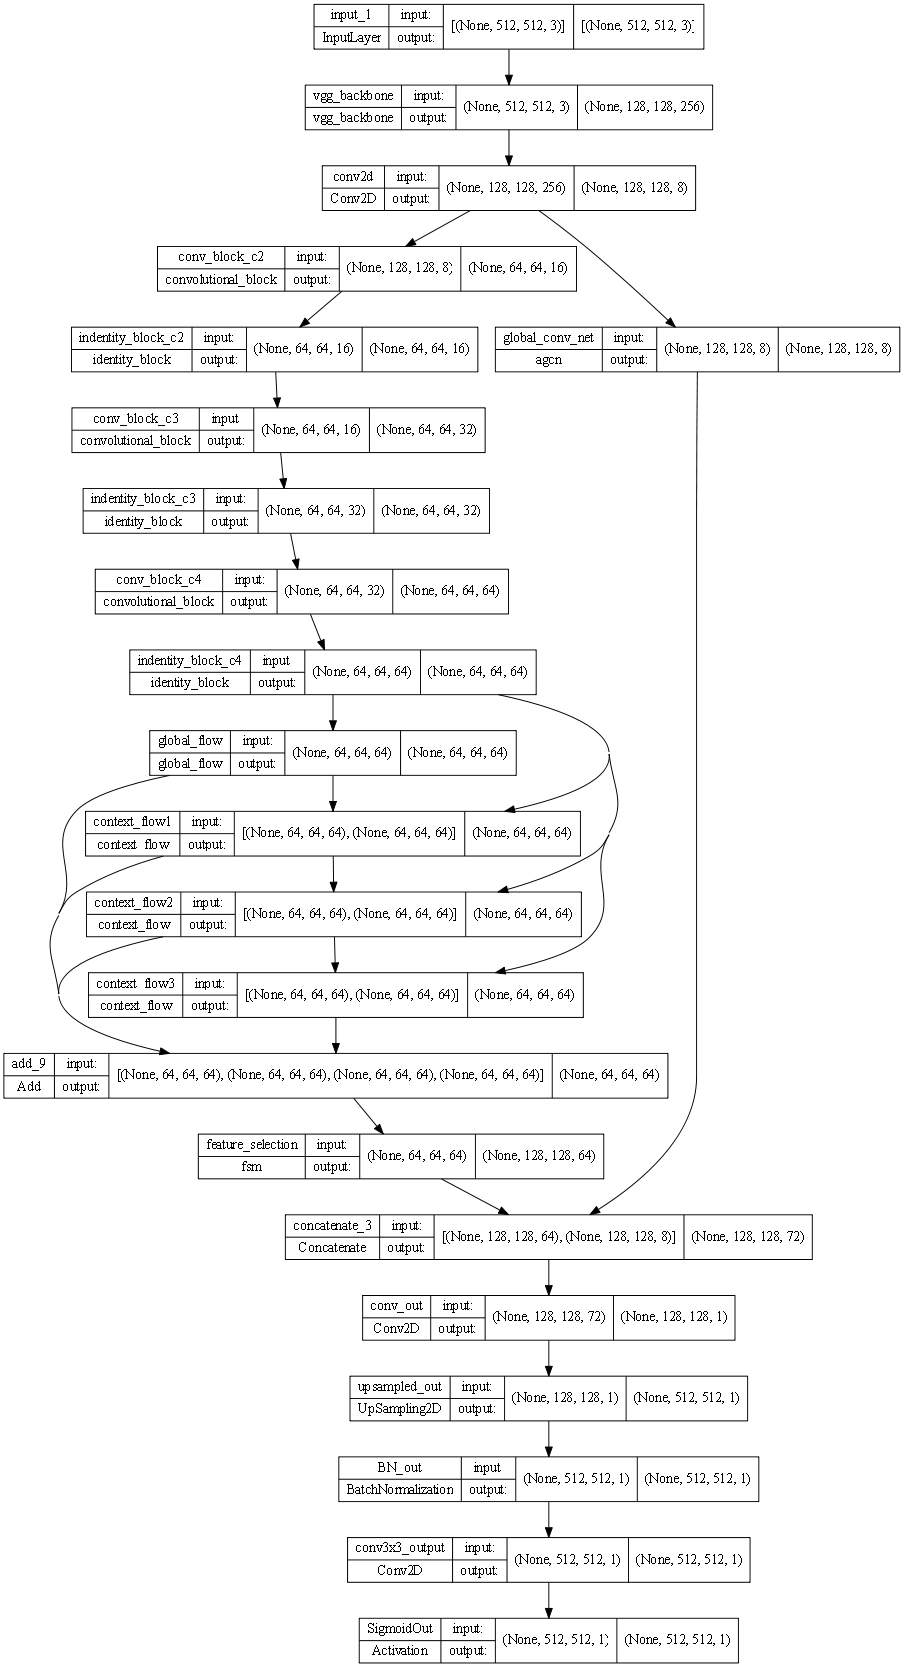

In [7]:
tf.keras.utils.plot_model(mm_model, show_shapes=True,to_file='custom_canet_model.png',dpi=70,show_layer_names=True,rankdir='TB')

In [8]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
tf.keras.backend.set_image_data_format('channels_last')

In [9]:
class Dataloder(tf.keras.utils.Sequence):
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()

    def __getitem__(self, i):
        
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

class ImageData4:
    def __init__(
        self, 
        annotations: COCO, 
        img_ids: List[int], 
        cat_ids: List[int], 
        root_path: Path, 
        augmentation=None, 
        preprocessing=None):
        
        super().__init__()
        
        self.annotations = annotations
        self.img_data = annotations.loadImgs(img_ids)
        self.cat_ids = cat_ids
        self.files = [f'{root_path}/{img["file_name"]}' for img in self.img_data] #image file paths
        self.preprocessing = preprocessing
        self.augmentation = augmentation
        
    def __len__(self) -> int:
        return len(self.files)
    
    def __getitem__(self, i: int):
        
        ann_ids = self.annotations.getAnnIds(imgIds=self.img_data[i]['id'], 
                                            catIds=self.cat_ids, 
                                            iscrowd=None)
        
        anns = self.annotations.loadAnns(ann_ids)
        mask = np.max(np.stack([self.annotations.annToMask(ann) * ann["category_id"] for ann in anns]), axis=0)
        mask = np.expand_dims(mask, axis=2)
        
        try:
            img = io.read_image(self.files[i])
        except:
            img = cv2.imread(self.files[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.augmentation:
            sample = self.augmentation(image=img, mask=mask)
            img, mask = sample['image'], sample['mask']
            
        if self.preprocessing:
            sample = self.preprocessing(image=img, mask=mask)
            img, mask = sample['image'], sample['mask']
        
        mask = mask.astype('float32')
        img = img.astype('float32')
            
        return img, mask

In [17]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n+1, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        image = (image-np.min(image))/(np.max(image)-np.min(image))
        plt.imshow(image)
    
    plt.subplot(1, n+1, i + 2)
    _im = (images['image'] - np.min(images['image']))/(np.max(images['image'])-np.min(images['image']))
    plt.imshow(_im)
    _m = (images['mask'] - np.min(images['mask']))/(np.max(images['mask'])-np.min(images['mask']))
    plt.imshow(_m, cmap='jet', alpha=0.4)
    plt.title('Mask Overlayed')
    plt.show()
    
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        A.RandomCrop(height=512, width=512, always_apply=True),
        A.IAAAdditiveGaussianNoise(p=0.4),
        A.IAAPerspective(p=0.2),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.6,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=0.5),
                A.Blur(blur_limit=3, p=0.5),
                A.MotionBlur(blur_limit=3, p=0.5),
            ],
            p=0.6,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=0.6),
                A.HueSaturationValue(p=0.6),
            ],
            p=0.6,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        A.Resize(512,512,always_apply=True)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [11]:
train_annotations = COCO('livecell_coco_train.json')
valid_annotations = COCO("livecell_coco_val.json")

cat_ids = train_annotations.getCatIds(supNms=["cell"])

train_img_ids = []
for cat in cat_ids:
    train_img_ids.extend(train_annotations.getImgIds(catIds=cat))
    
train_img_ids = list(set(train_img_ids))
print(f"Number of training images: {len(train_img_ids)}")

valid_img_ids = []
for cat in cat_ids:
    valid_img_ids.extend(valid_annotations.getImgIds(catIds=cat))
    
valid_img_ids = list(set(valid_img_ids))
print(f"Number of validation images: {len(valid_img_ids)}")

loading annotations into memory...
Done (t=27.71s)
creating index...
index created!
loading annotations into memory...
Done (t=5.28s)
creating index...
index created!
Number of training images: 3253
Number of validation images: 570


In [18]:
train_data = ImageData4(train_annotations, train_img_ids, cat_ids, 'livecell_train_val_images',augmentation=get_training_augmentation())
valid_data = ImageData4(valid_annotations, valid_img_ids, cat_ids, 'livecell_train_val_images',augmentation=get_validation_augmentation())

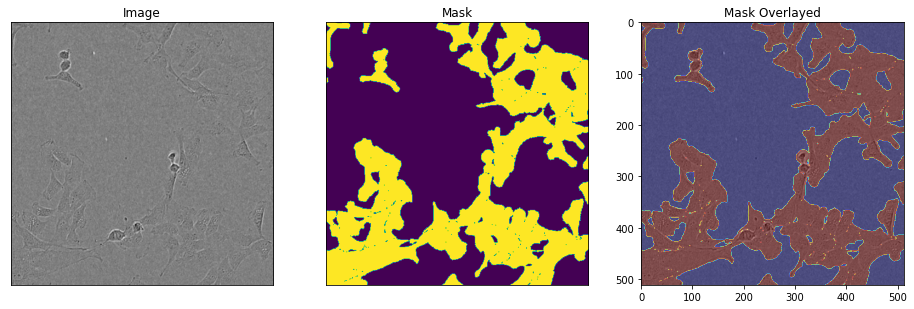

In [20]:
image, mask = train_data[199]
visualize(
    image=image, 
    mask=mask.squeeze())

In [21]:
BATCH_SIZE = 6
train_dataloader = Dataloder(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_data, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, 1)

In [23]:
steps_per_epoch = np.ceil(len(train_dataloader)/BATCH_SIZE)
validation_steps = np.ceil(len(valid_dataloader)/BATCH_SIZE)

print(steps_per_epoch,validation_steps)

optim = tf.keras.optimizers.Adam(0.002)

n_classes = 1
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

mm_model.compile(optim, total_loss, metrics)

91.0 16.0


In [24]:
history = mm_model.fit(train_dataloader, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=2,
                        validation_data=valid_dataloader,
                        validation_steps = validation_steps)

Epoch 1/2
91/91 [==============================] - 303s 3s/step - loss: 0.6972 - iou_score: 5.2713e-04 - f1-score: 0.0010 - val_loss: 0.7076 - val_iou_score: 2.0940e-11 - val_f1-score: 2.0940e-11
Epoch 2/2
91/91 [==============================] - 319s 4s/step - loss: 0.6924 - iou_score: 1.9598e-11 - f1-score: 1.9598e-11 - val_loss: 0.7077 - val_iou_score: 2.0940e-11 - val_f1-score: 2.0940e-11
